# Mendeteksi Lebah menggunakan Deep Learning

<p><img src="https://assets.datacamp.com/production/project_555/img/92_notebook.jpg" alt="honey bee">
<em>Lebah Madu (Apis).</em></p>
<p>Lebah madu dan lebah kumbang mempunyai perbedaan sifat dan rupa. Bisa dilihat di blog berikut: <a href="https://www.thesca.org/connect/blog/bumblebees-vs-honeybees-what%E2%80%99s-difference-and-why-does-it-matter">Perbedaan Lebah Madu dan Kumbang</a>
<p><img src="https://assets.datacamp.com/production/project_555/img/20_notebook.jpg" alt="bumble bee">
<em>Lebah Kumbang/Bumble Bee (Bombus).</em></p>
<p>Pada notebook ini kita akan membuat simple deep learning model yang dapat mendeteksi lebih tersebut dan menggunakan pre-trained model untuk evaluasi.</p>

In [2]:
import pickle
from pathlib import Path
from skimage import io

import pandas as pd # pd
import numpy as np # np

import matplotlib.pyplot as plt # plt

from sklearn.preprocessing import StandardScaler # Panggil StandardScaler
from sklearn.model_selection import train_test_split # Panggil train_test_split
from sklearn.metrics import classification_report # Panggil classification_report

# import keras library
import tensorflow as tf # tf

# import Sequential from the keras models module
from tensorflow.keras.models import Sequential # Sequential

# import Dense, Dropout, Flatten, Conv2D, MaxPooling2D from the keras layers module
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D # Panggil Dense, Dropout, Flatten, Conv2D, MaxPooling2D

## Buka dataset labels.csv

Kemudian kita bisa melihat dataset labels.csv dan perhatikan bagaimana data tersebut terstruktur. Kita akan load data tersebut kedalam pandas DataFrame dan kita bisa melihat bagaimana tabel label yang berisi nama gambar yang berkaitan dengan nomor index. Dan kolom genus memberikan informasi tentang tipe lebah. Kolom genus berisi nilai 0.0 untuk (Apis atau lebah madu) atau 1.0 untuk (Bombus atau lebah kumbang)

In [3]:
# load labels.csv from datasets folder using pandas
labels = pd.read_csv('C:/Users/CIRCLEK/DtSense/DTSense_Prediksi_Lebah/datasets/labels.csv',index_col=0) # read_csv('../datasets/labels.csv', _____=0) # index_col

# print value counts for genus
print(labels.genus.value_counts()) # subset genus dan panggil value_counts())

# assign the genus label values to y
y = labels.genus.values# subset genus dan panggil values 
labels

0.0    827
1.0    827
Name: genus, dtype: int64


,genus
id,
520,1.0
3800,1.0
3289,1.0
2695,1.0
4922,1.0
...,...
4439,0.0
3208,0.0
2365,0.0


# Analisa nilai RGB pada representasi Matrix

Image has shape: (200, 200, 3)
RGB values for the top left pixel are: [129 109 102]


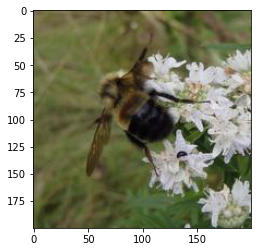

In [4]:
# load an image and explore
example_image = io.imread('../images/{}.jpg'.format(labels.index[0])) # imread('../images/{}.jpg'.format(labels.index[0]))

# show image
plt.imshow(example_image) # imshow(example_image)

# print shape
print('Image has shape:', example_image.shape)

# print color channel values for top left pixel
print('RGB values for the top left pixel are:', example_image[0, 0, :])

# Lakukan Normalisasi terhadap Nilai pada Matrix menggunakan StandardScaler

In [5]:
# initialize standard scaler
ss = StandardScaler()

image_list = []
X = np.array([])
for i in labels.index:
    # load image
    img = io.imread('../images/{}.jpg'.format(i)).astype(np.float64) # imread('../images/{}.jpg'.format(i)).astype(np.float64)
    
    # for each channel, apply standard scaler's fit_transform method
    for channel in range(img.shape[2]):
        img[:, :, channel] = ss.fit_transform(img[:, :, channel]) # fit_transform(img[:, :, channel])
        
    # append to list of all images
    if img.shape == (200, 200, 3): # Drop data yang mempunyai format yang berbeda dari (200, 200, 3)
        image_list.append(img) # Gunakan append(img) untuk image yang sudah sesuai formatnya
    else:
        drop = i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


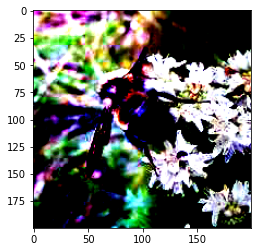

In [13]:
plt.imshow(image_list[0])

In [19]:
X = np.array(image_list) # convert list ke format array(image_list)

In [20]:
print(X.shape)

(1653, 200, 200, 3)


In [21]:
drop

1974

In [22]:
labels.loc[drop].name

1974

In [23]:
clean_df = labels.drop(labels.loc[1974].name) # drop(labels.loc[1974].name)

In [24]:
# print value counts for genus
print(clean_df.value_counts()) # subset genus dan panggil value_counts())

# assign the genus label values to y
y = clean_df.values# subset genus dan panggil values

genus
1.0      827
0.0      826
dtype: int64


# Split data menjadi train, test, dan evaluation sets

In [25]:
# split out evaluation sets (x_eval and y_eval)
x_interim, x_eval, y_interim, y_eval = train_test_split(X, y, test_size=0.2, random_state=52) # train_test_split(X, y, test_size=0.2, random_state=52)

# split remaining data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x_interim, y_interim, test_size=0.4, random_state=52) # train_test_split(x_interim, y_interim, test_size=0.4, random_state=52)

# examine number of samples in train, test, and validation sets
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print(x_eval.shape[0], 'eval samples')

x_train shape: (793, 200, 200, 3)
793 train samples
529 test samples
331 eval samples


# Membuat Model Part 1

Sekarang kita bisa membuat deep learning model menggunakan CNN (Convolutional Neural Network). CNN adalah salah satu tipe dari Deep Learning yang sangat efektif dalam melakukan klasifikasi gambar. Kita menggunakan TensorFlow 2.0 untuk membuat Sequential model, dimana kita bisa membuat tumpukan layer secara linear.

Untuk memahami CNN, bayangkan jika ada sebuah senter yang menyorot gambar dari sudut kiri atas yang meluncur sampai sudut kanan bawah gambar. Meluncur dari pixel ke pixel lain, seperti bagaimana cara kita membaca text dari kiri atas sampai ke kanan bawah halaman. Convolutional layer menggunakan kernel (sliding window) terhadap gambar dan melakukan element-wise matrix multiplication diantara kernel values dan pixel values dari gambar.

In [26]:
# set model constants
num_classes = 1 # kenapa satu, karena kita hanya ingin memprediksi dia dengan satu nilai yang mempunyai skala dari 0-1

# define model as Sequential
model = Sequential() # Sequential()

# first convolutional layer with 32 filters
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(200, 200, 3))) # add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(200, 200, 3)))

# add a second 2D convolutional layer with 64 filters
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu')) # add(Conv2D(64, kernel_size=(3, 3), activation='relu'))

# Membuat Model Part 2

<p>Sejauh ini kita sudah mempunyai dua convolutional layers. Namun, ada beberapa layer lain yang diperlukan untuk membuat Deep Learning model kita semakin memberikan hasil yang baik. Riset pada Deep Learning saat ini, lebih kearah bagaimana cara untuk menyusun struktur dari kumpulan layers menjadi sistem yang tepat untuk melakukan prediksi.

<p>Kita akan menambahkan layers berikut:</p>
<ul>
<li><a href="https://keras.io/layers/pooling/#maxpooling2d"><code>MaxPooling</code></a>. Max Pooling akan memberikan  moving window yang mempunyai dimensi (2, 2) pada gambar dan melakukan downscales/mereduksi size dari gambar dengan mengambil maximum value. </li>
<li><a href="https://keras.io/layers/convolutional/#conv2d"><code>Conv2D</code></a>. Kita bisa menambahkan kembali Convolutional Layer, maka ini adalah Convolutional layer yang ke tiga untuk membuat Deep Learning model kita semakin deep. Dengan menambahkan Convolutional Layer, maka model kita akan semakin baik untuk belajar fitur-fitur yang ada di gambar.</li>
<li><a href="https://keras.io/layers/core/#dropout"><code>Dropout</code></a>. Dropout Layer secara random akan me non aktifkan beberapa unit neuron yang ada pada setiap layer. Menggunakan teknik Dropout mampu mencegah model dari overfitting. Konsep Dropout mencegah overfitting adalah dengan mencegah proses belajar hanya terpusat pada beberapa unit neuron saja, sedangkan unit neuron yang lain tidak belajar dengan baik.</li>
<li><a href="https://keras.io/layers/core/#flatten"><code>Flatten</code></a>. Flatten layer adalah layer output yang berasal dari convolutional layer, biasanya setelah ketika kita memanggil Flatten maka selanjutnya kita bisa menghubungkan dengan fully connected layers.</li>
<li><a href="https://keras.io/layers/core/#dense"><code>Dense</code></a>. Fully connected layer dimana setiap input akan dikoneksikan dengan setiap output (lihat gambar dibawah ini).</li>
<li><a href="https://keras.io/layers/core/#dropout"><code>Dropout</code></a>. Dropout layer yang lain untuk memastikan model kita tidak overfitting, kali ini dengan rate 50%.</li>
<li><code>Dense</code>. Final layer yang melakukan kalkulasi nilai probabilitas diantara lebah madu atau lebah kumbang.</li>
</ul>
<p>Untuk melihat semua layer yang sudah disusun, kita bisa melihatnya dari model summary. Kita bisa memperhatikan bahwa mode kita memiliki <code>75,554,049</code> paramaters. Ini adalah nilai bobot yang model kita buat dan kita update selama proses training dan bobot ini digunakan untuk generate predictions terhadap gambar yang baru.</p>
<p><img src="https://assets.datacamp.com/production/project_555/img/mlp_conv.png" alt></p>

In [27]:
# reduce dimensionality through max pooling
model.add(MaxPooling2D(pool_size=(2, 2))) # add(MaxPooling2D(pool_size=(2, 2)))

# third convolutional layer with 64 filters
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu')) # add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
# add dropout to prevent over fitting
model.add(Dropout(0.25)) # add(Dropout(0.25))
# necessary flatten step preceeding dense layer
model.add(Flatten()) # add(Flatten())
# fully connected layer
model.add(Dense(128, activation='relu')) # add(Dense(128, activation='relu'))

# add additional dropout to prevent overfitting
model.add(Dropout(0.5)) # add(Dropout(0.5))

# prediction layers
model.add(Dense(num_classes, activation='sigmoid', name='preds')) # add(Dense(num_classes, activation='sigmoid', name='preds'))

# show model summary
model.summary() # summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 198, 198, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 196, 196, 64)      18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 98, 98, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 96, 96, 64)        36928     
_________________________________________________________________
dropout (Dropout)            (None, 96, 96, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 589824)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               7

# Compile and train model

In [32]:
model.compile(
    # set the loss as binary_crossentropy
    loss=tf.keras.losses.binary_crossentropy, # tf.keras.losses.binary_crossentropy,
    # set the optimizer as stochastic gradient descent
    optimizer='adam', # 'adam',
    # set the metric as accuracy
    metrics=['accuracy'] # ['accuracy']
)

# mock-train the model using the first ten observations of the train and test sets
hist = model.fit(
    x_train[:100, :, :, :],
    y_train[:100],
    epochs=20, # 20,
    verbose=1, # 1,
    validation_data=(x_test[:100, :, :, :], y_test[:100]) # validation_data=(x_test[:100, :, :, :], y_test[:100])
)

Epoch 1/20
4/4 [==============================] - 40s 9s/step - loss: 4.0273 - accuracy: 0.4880 - val_loss: 1.7287 - val_accuracy: 0.4600
Epoch 2/20
4/4 [==============================] - 31s 8s/step - loss: 0.7563 - accuracy: 0.6062 - val_loss: 0.7323 - val_accuracy: 0.5200
Epoch 3/20
4/4 [==============================] - 29s 7s/step - loss: 0.3690 - accuracy: 0.8772 - val_loss: 2.1448 - val_accuracy: 0.4700
Epoch 4/20
4/4 [==============================] - 30s 8s/step - loss: 0.6147 - accuracy: 0.7464 - val_loss: 0.7106 - val_accuracy: 0.5500
Epoch 5/20
4/4 [==============================] - 30s 8s/step - loss: 0.1949 - accuracy: 0.9444 - val_loss: 0.6723 - val_accuracy: 0.6600
Epoch 6/20
4/4 [==============================] - 29s 7s/step - loss: 0.0942 - accuracy: 1.0000 - val_loss: 0.9429 - val_accuracy: 0.5400
Epoch 7/20
4/4 [==============================] - 28s 7s/step - loss: 0.0956 - accuracy: 0.9632 - val_loss: 0.8632 - val_accuracy: 0.6500
Epoch 8/20
4/4 [==================

In [36]:
model.save('../models/DTSense_model_nama.h5') # save('models/DTSense_model_nama.h5')

# Load pre-trained model and score

In [38]:
# load pre-trained model
pretrained_cnn = tf.keras.models.load_model("../models/DTSense_model_nama.h5") # models.load_model("../models/DTSense_model.h5")

# evaluate model on test set
score = pretrained_cnn.evaluate(x_test, y_test, verbose=0) # evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0]) # score[0])
print('Test accuracy:', score[1]) # score[1])

print("")

Test loss: 1.5746052265167236
Test accuracy: 0.4952740967273712



Eval loss: 1.7352045774459839
Eval accuracy: 0.4984894394874573


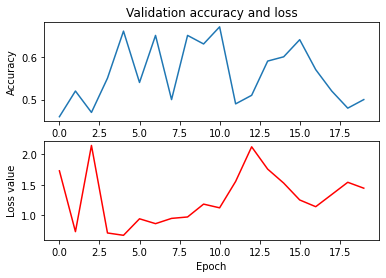

In [39]:
# evaluate model on holdout set
eval_score = pretrained_cnn.evaluate(x_eval, y_eval, verbose=0) # evaluate(x_eval, y_eval, verbose=0)
# print loss score
print('Eval loss:', eval_score[0])
# print accuracy score
print('Eval accuracy:', eval_score[1])
pretrained_cnn_history = hist
# print keys for pretrained_cnn_history dict
#print(pretrained_cnn_history.keys())

fig = plt.figure(1)
plt.subplot(211)
# plot the validation accuracy
plt.plot(pretrained_cnn_history.history['val_accuracy'])
plt.title('Validation accuracy and loss')
plt.ylabel('Accuracy')
plt.subplot(212)
# plot the validation loss
plt.plot(pretrained_cnn_history.history['val_loss'], 'r')
plt.xlabel('Epoch')
plt.ylabel('Loss value');


In [40]:
# predicted probabilities for x_eval
y_proba = pretrained_cnn.predict(x_eval) # predict(x_eval)

print("First five probabilities:")
print(y_proba[:5])
print("")

# predicted classes for x_eval
y_pred = np.round(y_proba).astype('int') # np.round(y_proba).astype('int')

print("First five class predictions:")
print(y_pred[:5])
print("")


First five probabilities:
[[0.00087535]
 [0.14038298]
 [0.0151388 ]
 [0.02306539]
 [0.04937956]]

First five class predictions:
[[0]
 [0]
 [0]
 [0]
 [0]]

